## SwAV ImageWang Tutorial

First import **fastai** for training and other helpers, you can choose not to use **wandb** by setting `WANDB=False`.

In [1]:
from fastai.vision.all import *
from fastai.callback.wandb import WandbCallback
import wandb

WANDB = False

Then import **self_supervised** `augmentations` module for creating augmentations pipeline, `layers` module for creating encoder and model, and finally `swav` for self-supervised training.

In [2]:
from self_supervised.augmentations import *
from self_supervised.layers import *
from self_supervised.vision.swav import *

In this notebook we will take a look at [ImageWang](https://github.com/fastai/imagenette#image%E7%BD%91) benchmark, how to train a self-supervised model using SwAV algorithm and then how to use this pretrained model for finetuning on the given downstream task. 

**Warning**: This notebook actually reaches best public leaderboard score 😃

## Pretraining

In [4]:
def get_dls(size, bs, workers=None):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    
    files = get_image_files(source)
    tfms = [[PILImage.create, ToTensor, RandomResizedCrop(size, min_scale=1.)], 
            [parent_label, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=RandomSplitter(valid_pct=0.1)(files))
    
    batch_tfms = [IntToFloatTensor]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    return dls

ImageWang has several benchmarks for different image sizes, in this tutorial we will go for `size=224` and also demonstrate how effectively you can utilize GPU memory.

Define batch size, resize resolution before batching and size for random cropping during self-supervised training.

In [5]:
bs, resize, size = 96, 256, 224

Set queue size, it needs to be a multiple of batch size.

In [6]:
K = bs*2**4

Select architecture to train on, remember all **timm** and **fastai** models are available! We need to set `pretrained=False` here because using imagenet weights for ImageWang data would be cheating.

In [7]:
arch = "xresnet34"
encoder = create_encoder(arch, pretrained=False, n_in=3)

In [8]:
if WANDB:
    xtra_config = {"Arch":arch, "Resize":resize, "Size":size, "Algorithm":"SWAV"}
    wandb.init(project="self-supervised-imagewang", config=xtra_config);

Initialize the Dataloaders using the function above.

In [9]:
dls = get_dls(resize, bs)

Create SwAV model. You can change values of `hidden_size`, `projection_size`, `n_protos` -  number of prototypes/psuedo classes for cluster assignment. If defaults are not working for your problem try changing `n_protos` first. For this problem, defaults work just fine so we don't do any changes.

In [10]:
model = create_swav_model(encoder)

Next step is perhaps the most critical step for achieving good results on a custom problem - data augmentation. For this, we will use utility function from `self_supervised.vision.swav.get_swav_aug_pipelines` but you can also use your own list of Pipeline augmentations. `self_supervised.vision.swav.get_swav_aug_pipelines`should be enough for most of the cases since under the hood it uses `self_supervised.augmentations.get_multi_aug_pipelines` and `self_supervised.augmentations.get_batch_augs`. You can do shift+tab and see all the arguments that can be passed to `get_swav_aug_pipelines`. You can simply pass anything that you could pass to `get_batch_augs` including custom `xtra_tfms`.

`get_swav_aug_pipelines` excepts certain arguments, for more detail please visit SwAV's documentation. To briefly explain, here we define **2 large crops** and **6 smaller crops** which are in **size** and **int(3/4*size)** pixel resolution respectively. We also set RandomResizedCrop scales for large crops to **(0.25 - 1.0)** and for smaller crops to **(0.2, 0.35)**. Rest of the arguments are coming from `get_batch_augs()`

In [14]:
aug_pipelines = get_swav_aug_pipelines(num_crops=[2,6],
                                       crop_sizes=[size,int(3/4*size)], 
                                       min_scales=[0.25,0.2],
                                       max_scales=[1.0,0.35],
                                       rotate=True, rotate_deg=10, jitter=True, bw=True, blur=False) 

Finally we need to pass the indexes of large crops to `crop_assgn_ids`, since we defined the first 2 crops as large in our aug_pipelines indexes will be 0 and 1. I also set queue start to 0.5, I found it to be a good value.

In [15]:
cbs=[SWAV(aug_pipelines, crop_assgn_ids=[0,1], K=K, queue_start_pct=0.5, temp=0.1)]
if WANDB: cbs += [WandbCallback(log_preds=False,log_model=False)]

In [16]:
learn = Learner(dls, model, cbs=cbs)

Before starting training let's check whether our augmentations makes sense or not. Since this step consumes GPU memory, once you are done with inspection, restart the notebook and skip this step. We can see that first 2 crops are the larger ones and indeed augmentations look pretty good. Now, it's time restart the notebook and skip this step.

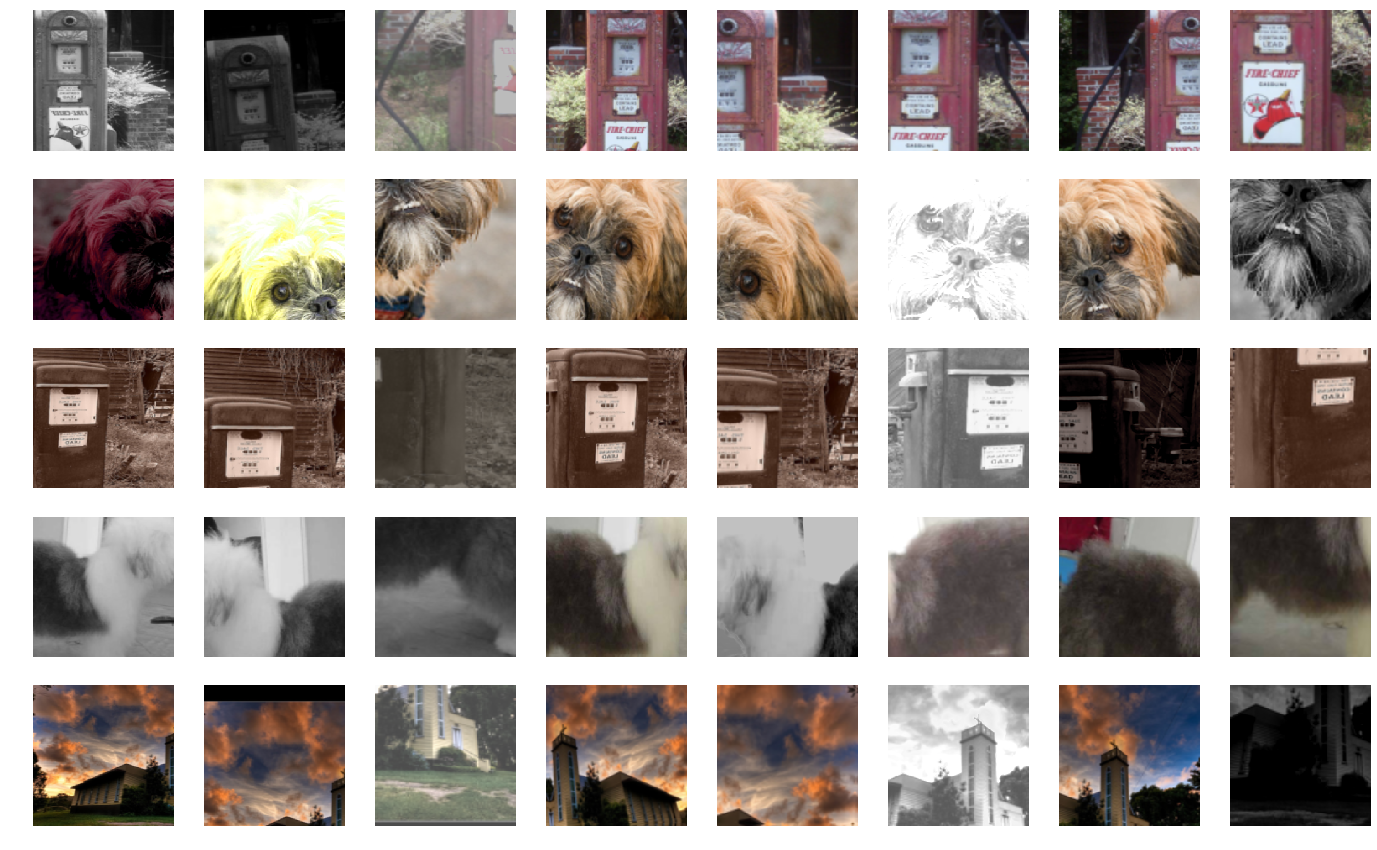

In [14]:
b = dls.one_batch()
learn._split(b)
learn('before_batch')
learn.swav.show(n=5);

For more GPU memory, larger batch size and faster training use mixed precision with `to_fp16()`. We could also use gradient checkpointing wrapper models from `self_supervised.layers` to save even more memory, e.g. `CheckpointSequential()`.

In [17]:
learn.to_fp16();

Learning good representations via contrastive learning usually takes a lot of epochs. So here number epochs are set to 100. This might change depending on your data distribution and dataset size.

In [18]:
lr,wd,epochs=1e-2,1e-2,100

In [10]:
learn.unfreeze()
learn.fit_flat_cos(epochs, lr, wd=wd, pct_start=0.5)

epoch,train_loss,valid_loss,time
0,7.407468,7.684866,02:58
1,7.030927,7.189878,02:52
2,6.837667,6.869849,02:52
3,6.633281,7.156127,02:52
4,6.468298,6.766192,02:54
5,6.345496,6.350045,02:53
6,6.241495,6.387009,02:54
7,6.162815,6.393086,02:53
8,6.081127,6.323627,02:53
9,5.999241,6.243154,02:51


In [ ]:
if WANDB: wandb.finish()

In [12]:
save_name = f'swav_iwang_sz{size}_epc{epochs}'
learn.save(save_name)
torch.save(learn.model.encoder.state_dict(), learn.path/learn.model_dir/f'{save_name}_encoder.pth')

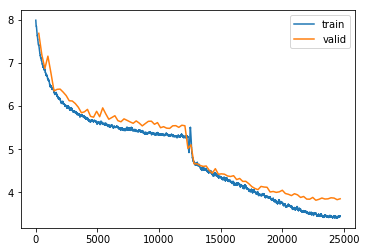

In [13]:
learn.recorder.plot_loss()

## Downstream Task

In [3]:
optdict = dict(sqr_mom=0.99,mom=0.95,beta=0.,eps=1e-4)
opt_func = partial(ranger, **optdict)

In [14]:
bs, size

(96, 224)

In [15]:
def get_dls(size, bs, workers=None):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    files = get_image_files(source, folders=['train', 'val'])
    splits = GrandparentSplitter(valid_name='val')(files)
    
    item_aug = [RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)]
    tfms = [[PILImage.create, ToTensor, *item_aug], 
            [parent_label, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=splits)
    
    batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    return dls

In [16]:
def split_func(m): return L(m[0], m[1]).map(params)

def create_learner(size=size, arch='xresnet34', encoder_path="models/swav_iwang_sz128_epc100_encoder.pth"):
    
    dls = get_dls(size, bs=bs//2)
    pretrained_encoder = torch.load(encoder_path)
    encoder = create_encoder(arch, pretrained=False, n_in=3)
    encoder.load_state_dict(pretrained_encoder)
    nf = encoder(torch.randn(2,3,224,224)).size(-1)
    classifier = create_cls_module(nf, dls.c)
    model = nn.Sequential(encoder, classifier)
    learn = Learner(dls, model, opt_func=opt_func, splitter=split_func,
                metrics=[accuracy,top_k_accuracy], loss_func=LabelSmoothingCrossEntropy())
    return learn

In [17]:
def finetune(size, epochs, arch, encoder_path, lr=1e-2, wd=1e-2):
    learn = create_learner(size, arch, encoder_path)
    learn.unfreeze()
    learn.fit_flat_cos(epochs, lr, wd=wd)
    final_acc = learn.recorder.values[-1][-2]
    return final_acc

### 5 epochs

In [18]:
acc = []
runs = 5
for i in range(runs): acc += [finetune(size, epochs=5, arch='xresnet34', encoder_path=f'models/swav_iwang_sz{size}_epc100_encoder.pth')]

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.983487,1.558032,0.711631,0.921354,00:58
1,0.907253,1.474977,0.730211,0.930517,00:58
2,0.878498,1.430007,0.734284,0.932298,01:00
3,0.826681,1.326239,0.759990,0.948333,00:58
4,0.735671,1.216653,0.794350,0.960295,00:58


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.002475,1.796736,0.648002,0.900229,00:59
1,0.908794,1.402081,0.744719,0.931535,00:58
2,0.858086,1.445738,0.716722,0.933062,00:58
3,0.811090,1.300391,0.776024,0.954441,00:59
4,0.740800,1.217372,0.798167,0.957750,00:58


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.986952,1.708992,0.659964,0.904301,00:59
1,0.937269,1.404593,0.747264,0.942479,00:59
2,0.864935,1.405310,0.750318,0.939425,00:58
3,0.810867,1.288793,0.768389,0.949860,00:58
4,0.742714,1.219064,0.803003,0.958514,00:59


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.968935,1.604818,0.687198,0.940952,00:58
1,0.924613,1.683160,0.633749,0.912955,00:56
2,0.844297,1.621276,0.671418,0.914228,00:55
3,0.825853,1.351661,0.755918,0.949351,00:55
4,0.743408,1.207588,0.789259,0.955968,00:56


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.965100,1.479348,0.741156,0.943752,00:56
1,0.920319,1.532363,0.723085,0.930262,00:55
2,0.845511,1.352898,0.751082,0.940188,00:54
3,0.820847,1.341636,0.766607,0.951642,00:55
4,0.740365,1.209206,0.793332,0.957241,00:53


In [19]:
np.mean(acc)

0.7956223011016845

### 20 epochs

In [20]:
acc = []
runs = 3
for i in range(runs): acc += [finetune(size, epochs=20, arch='xresnet34', encoder_path=f'models/swav_iwang_sz{size}_epc100_encoder.pth')]
np.mean(acc)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.971454,1.545572,0.708323,0.921354,00:54
1,0.927443,1.499802,0.721303,0.939679,00:54
2,0.873696,1.475774,0.729448,0.940443,00:54
3,0.803617,1.430663,0.724103,0.944261,00:54
4,0.803485,1.309435,0.775006,0.945024,00:54
5,0.766212,1.365433,0.744464,0.941715,00:54
6,0.753622,1.369751,0.731738,0.941970,00:54
7,0.743506,1.371420,0.760499,0.940697,00:56
8,0.726871,1.382386,0.747518,0.948587,00:53
9,0.720248,1.393038,0.751082,0.943752,00:54


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.963382,1.713247,0.656656,0.932044,00:56
1,0.931585,1.536007,0.724357,0.937643,00:55
2,0.851089,1.420539,0.756172,0.949606,00:54
3,0.817316,1.328225,0.764062,0.938407,00:54
4,0.793688,1.371521,0.735811,0.932044,00:54
5,0.778133,1.326565,0.766353,0.949351,00:56
6,0.748602,1.449237,0.734029,0.937134,00:55
7,0.751250,1.322996,0.754390,0.945024,00:56
8,0.734199,1.411296,0.729702,0.936880,00:55
9,0.727239,1.264135,0.772970,0.957496,00:56


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.985622,1.549440,0.721812,0.921863,00:56
1,0.917132,1.575578,0.733265,0.920081,00:56
2,0.857101,1.328448,0.764571,0.956986,00:54
3,0.824363,1.346856,0.765589,0.946551,00:54
4,0.794153,1.344439,0.756681,0.948842,00:54
5,0.771290,1.381032,0.756681,0.947569,00:54
6,0.761646,1.365927,0.754645,0.947315,00:54
7,0.734839,1.393742,0.755154,0.936371,00:54
8,0.744643,1.329592,0.759226,0.945788,00:54
9,0.723056,1.427026,0.728430,0.933825,00:54


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



### 80 epochs

In [21]:
acc = []
runs = 1
for i in range(runs): acc += [finetune(size, epochs=80, arch='xresnet34',encoder_path=f'models/swav_iwang_sz{size}_epc100_encoder.pth')]
np.mean(acc)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.969396,1.548739,0.710104,0.932553,00:54
1,0.910081,1.519832,0.713668,0.939170,00:55
2,0.853625,1.308844,0.771443,0.944770,00:54
3,0.823330,1.447318,0.729702,0.926190,00:55
4,0.789518,1.322515,0.770171,0.954950,00:54
5,0.774128,1.364938,0.759481,0.939170,00:55
6,0.758874,1.454771,0.720031,0.929244,00:55
7,0.747683,1.323867,0.751082,0.946042,00:54
8,0.731047,1.421696,0.727921,0.933316,00:54
9,0.729223,1.306388,0.767116,0.949096,00:54


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

0.7627894878387451

### 200 epochs

In [ ]:
acc = []
runs = 1
for i in range(runs): acc += [finetune(size, epochs=200, arch='xresnet34', encoder_path=f'models/swav_iwang_sz{size}_epc100_encoder.pth')]
np.mean(acc)

epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,0.984085,1.678459,0.670654,0.933825,00:54
1,0.922175,1.501608,0.704759,0.941461,00:54
2,0.854042,1.435633,0.751591,0.942734,00:55
3,0.826787,1.373917,0.754136,0.943497,00:54
4,0.789434,1.392040,0.741919,0.947824,00:54
5,0.776616,1.347452,0.751336,0.944770,00:54
6,0.751912,1.359706,0.756172,0.951387,00:54
7,0.753233,1.408145,0.728175,0.939425,00:55
8,0.747958,1.393444,0.749809,0.944006,00:53
9,0.727515,1.344913,0.763808,0.945533,00:54


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceed

In [24]:
np.mean(acc)

0.7314838171005249